This notebook is designed to walk the user through the classes included in lvlspy. This first thing to do is to quietly install and import any missing python packages this notebook will use

In [1]:
import sys, subprocess, pkg_resources
required = {'numpy','lvlspy','matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    subprocess.check_call([sys.executable, '-m','pip','install','--quiet',*missing])


import numpy as np
import lvlspy.level as lv
import lvlspy.species as ls
import lvlspy.transition as lt
import matplotlib.pyplot as plt

You can create an array of levels with input of energy and multiplicity. The default unit for energy is in keV

In [11]:
levs = [lv.Level(0,1),lv.Level(100,1,units="GeV"),lv.Level(500,3,units="eV"),lv.Level(200,4,units = "MeV")]

You can associate the levels with a species. For our purposes, we shall call it test and print out the levels. The energy will be print out in kev

In [12]:
s = ls.Species('test',levels=levs)
for lev in s.get_levels():
    print(lev.get_energy(), lev.get_multiplicity())

0.0 1
0.5 3
200000.0 4
100000000.0 1


The levels need not be specified from the start, you can add or remove on the fly

In [14]:
# Add another level.

s.add_level(lv.Level(300, 3))

# Remove a level
s.remove_level(lv.Level(200, 4,units = 'MeV')) 

# Print out levels again. 

for lev in s.get_levels():
    print(lev.get_energy(), lev.get_multiplicity())


0.0 1
0.5 3
300.0 3
300.0 3
100000000.0 1


Create the levels and add them to the species.

In [2]:
levs = [lv.Level(0,1),lv.Level(100,1),lv.Level(500,3),lv.Level(200,4),lv.Level(300,3)]

my_species = ls.Species('my_species',levels = levs)

You can update optional properties for any level. In this example, we will update properties for level 0

In [ ]:
levs[0].update_properties({'color': 'black'})
levs[0].update_properties({'smell': 'stinky'})
levs[0].update_properties({'smell': 'nice'})
levs[0].update_properties({('first name', 'last name'): ('Jaad', 'Tannous')})

# Print out level properties

for prop in levs[0].get_properties():
    print(prop, ':', levs[0].get_properties()[prop])

You can also update the optional properties for the species

In [ ]:
s.update_properties({'Motto': 'Go Tigers!'})
s.update_properties({('key1', 'key2', 'key3'): ('value1', 'value2', 'value3')})

# Print out species properties

for prop in s.get_properties():
    print(prop, ':', s.get_properties()[prop])

The API allows for the calculation of downwards transitions if you supply the Einstein A coefficient and add optional properties to it

In [ ]:
t = lt.Transition(levs[1], levs[0], 100.)

# Update optional properties for transition

t.update_properties({'Name': 'Fast'})

# Print out transition properties

for prop in t.get_properties():
    print(prop, ':', t.get_properties()[prop])


The remaining properties of the transition can be calculated as well

In [ ]:
# Print the Einstein coefficients for the transition

print(t.get_upper_level().get_energy(), t.get_lower_level().get_energy(),
      t.get_Einstein_A(), t.get_Einstein_B_upper_to_lower(),
      t.get_Einstein_B_lower_to_upper())

# Print the frequency for the transition

print('nu (per second) =', t.get_frequency())

For a given temperature, in Kelvin, you can compute the transition rates

In [ ]:
T = 1.e9

print(t.compute_upper_to_lower_rate(T), t.compute_lower_to_upper_rate(T))

# Compute and print out the equilibrium probabilities

p = s.compute_equilibrium_probabilities(T)

for i in range(len(p)):
    print('Level =', i, ', Probability =', p[i])

You can also add the transitions to the species 

In [ ]:
s.add_transition(t)

print('New number of transitions =', len(s.get_transitions()))

for tr in s.get_transitions():
    print('A:', t.get_Einstein_A())


The rate matrix can be calculated for the number of transitions and temperature supplied

In [ ]:
print('\nRate Matrix:\n')

for i in range(rate_matrix.shape[0]):
    for j in range(rate_matrix.shape[1]):
        print(i, j, rate_matrix[i, j])

The API can be used for equilibrium calculations. Let's create a non-real example and evolve it in time at constant temperature

In [ ]:
levs = [lv.Level(0,1),lv.Level(100,1),lv.Level(500,3),lv.Level(200,4),lv.Level(300,3)]

my_species = ls.Species('my_species',levels = levs)

my_levs = my_species.get_levels()

for i in range(len(my_levs)-1,0,-1):
    for j in range(i-1,-1,-1):
        t = lt.Transition(my_levs[i],my_levs[j],100.)
        my_species.add_transition(t)

T = 2e+9 #temperature in Kelvin

Compute the rate matrix.

In [5]:
rate_matrix = my_species.compute_rate_matrix(T)

Now that everything required to solve the differential equation $\frac{dY}{dt} = \Lambda Y$, we set up a Newton-Raphson solver. The following definition calculates the vector f in the equation $A\delta = -f$

In [6]:
def f_vector(y_dt,y_i,A):
    return np.matmul(A,y_dt) - y_i

The following contains the setup and loop for the Newton-Raphson solver. If you are unfamiliar with the method, it is fully described at [webnucleo.org](https://webnucleo.readthedocs.io/en/latest/jupyter_notebooks.html)

In [7]:
tol = 1.e-6 #convergence tolerance on newton raphson solver 
t = np.linspace(0,1,1000)
dt = t[1] - t[0]
y = np.array([1.,0,0,0,0])
A = np.identity(5) - dt*rate_matrix
y_dt = y
y = y_dt
Y = np.empty((5,len(t)))
Y[:,0] = y

for i in range(1,len(t)): 
    delta = np.ones(5)
    while max(delta) > tol:
        delta = np.linalg.solve(A,-f_vector(y_dt,y,A))
        y_dt = y_dt + delta
    Y[:,i] = y_dt
    y = y_dt

Compute the equilibrium probabilities

In [8]:
eq_probs = my_species.compute_equilibrium_probabilities(T)

Plot the probabilities vs. time.  Plot the equilibrium probabilities for comparison.

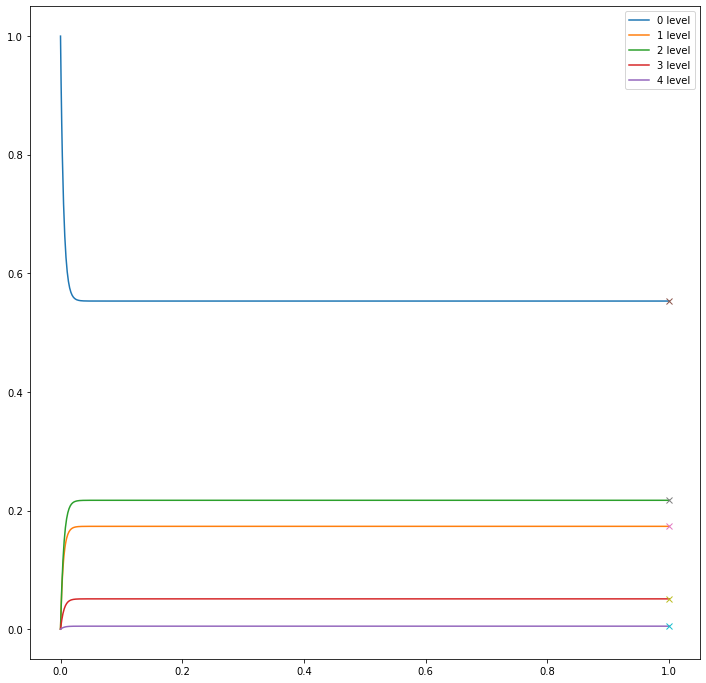

In [9]:
plt.figure(figsize=(12,12))
for i in range(len(my_levs)):
    plt.plot(t,Y[i,:],label = str(i) + ' level')
        
for i in range(len(eq_probs)):
    plt.plot(1, eq_probs[i], 'x')

plt.legend()
plt.show()

Compute and plot the fugacities.

(0.0, 0.1)

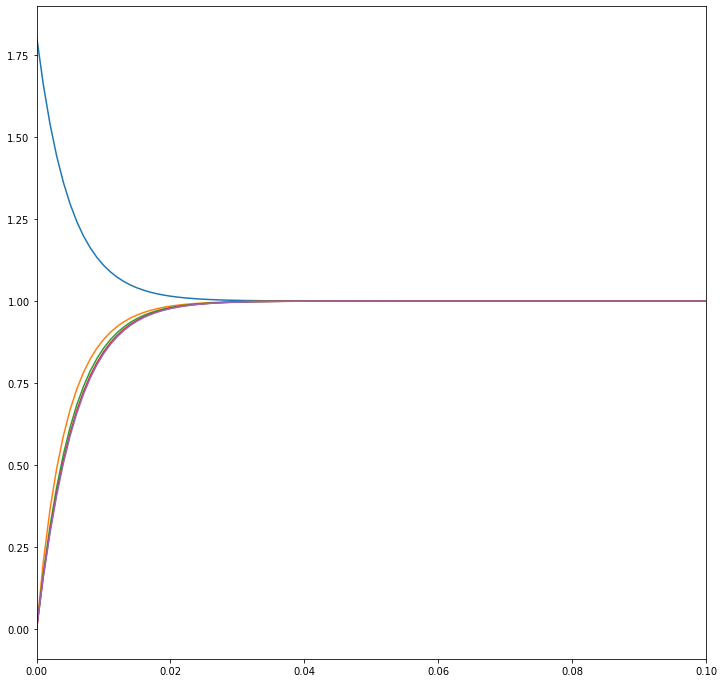

In [10]:
fugacities = np.empty((Y.shape[0], Y.shape[1]))

for i in range(len(my_levs)):
    fugacities[i, :] = Y[i, :] / eq_probs[i]
    
plt.figure(figsize=(12,12))
for i in range(len(my_levs)):
    plt.plot(t,fugacities[i,:],label = str(i) + ' level')
    
plt.xlim([0,0.1])